In [1]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import glob
import numpy as np
import pandas as pd
import cv2

C:\Users\woodw\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\woodw\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from keras.layers import Input, merge, Concatenate, Dense, Dropout, Conv2D, Add, Dot, Lambda, Conv2DTranspose, Dot, Activation, Reshape, BatchNormalization, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Multiply, LeakyReLU, Flatten, MaxPool2D, MaxPool3D, Embedding, GRU
from keras.layers.convolutional import Convolution2D, UpSampling2D, SeparableConv2D, UpSampling3D
from keras.layers import PReLU, LeakyReLU
from keras.models import Model
from keras.models import load_model
import keras.backend as K
from keras import layers
from keras import activations
from keras.preprocessing.sequence import pad_sequences

from nltk.tokenize import sent_tokenize, word_tokenize 
import tensorflow as tf

Using TensorFlow backend.


In [3]:
img_paths = glob.glob('cleaned-data\*.jpg')

In [4]:
captions = pd.read_csv('./coco-captions-2017-clean.csv')

In [5]:
len(captions)

118287

In [6]:
annot_list = captions.values[:1600]
data = [] 
corpus_dict = {}
# iterate through each caption 
max_sequence_length = float("-inf")
for row in annot_list: 
    temp = [] 
      
    #tokenize the captions into words 
    for j in word_tokenize(row[2]): 
        temp.append(j.lower()) 
        corpus_dict[j.lower()] = 0
    if len(temp) > max_sequence_length:
        max_sequence_length = len(temp)
    data.append(temp) 

for index, word in enumerate(corpus_dict.keys()):
    corpus_dict[word] = index + 1
    
corpus_size = len(corpus_dict.keys())

In [7]:
len(corpus_dict.keys())

1875

In [8]:
w2v_model = Word2Vec.load('./text_encoding.bin')

In [9]:
len(w2v_model.wv.vocab)

13896

In [10]:
captions_X = []
caption_strings = []

for row in annot_list:
    caption_conv = []
    for word in word_tokenize(row[2].lower()):
        caption_conv.append(w2v_model[word])
    captions_X.append(np.array(caption_conv))
    caption_strings.append(row[2].lower())
    
    
    

C:\Users\woodw\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [11]:
len(w2v_model.wv.vocab)

13896

In [12]:
# Pad with 0-vectors
for i in range(len(captions_X)):
    captions_X[i].resize((27, 100))


In [13]:
captions_X = np.array(captions_X)

In [14]:
len(captions_X)

1600

In [15]:
# annot_df = pd.read_csv('./coco-captions-2017-clean.csv')
# annot_list = annot_df.values[:1167]
# data = [] 
# corpus_dict = {}
# # iterate through each caption 
# max_sequence_length = float("-inf")
# for row in annot_list: 
#     temp = [] 
      
#     #tokenize the captions into words 
#     for j in word_tokenize(row[2]): 
#         temp.append(j.lower()) 
#         corpus_dict[j.lower()] = 0
#     if len(temp) > max_sequence_length:
#         max_sequence_length = len(temp)
#     data.append(temp) 
  
# for index, word in enumerate(corpus_dict.keys()):
#     corpus_dict[word] = index + 1
    
# corpus_size = len(corpus_dict.keys())
# print("corpus size: {}".format(corpus_size))
# print("max sequence length: {}".format(max_sequence_length))

In [15]:
def data_loader(file_path):
    img_paths = glob.glob(file_path + '/*')
    data = []
    for img_path in img_paths:
        
        data.append(cv2.imread(img_path) / 255.0)
    return np.array(data)

In [16]:
imgs_all = data_loader('./cleaned-data/')
imgs_y = imgs_all[:1600]

In [67]:
# autoencoder = load_model('./autoencoder-v2-models/autoencoder-v2-9k-epochs.h5')
import keras.metrics
def image_closeness(y_pred, y_true):
    return K.mean(1 - K.abs(y_pred - y_true), axis=-1)
keras.metrics.image_closeness = image_closeness

# autoencoder = load_model('./autoencoder-v3-models/autoencoder-v3-2k-epochs.h5')
autoencoder = load_model('./autoencoder-v2-models/autoencoder-v2-9k-epochs.h5')

In [68]:
decoder = autoencoder.layers[2]

In [69]:
for layer in decoder.layers:
    layer.trainable = False
decoder.trainable = False

In [83]:
def build_intermediate_model(input_shape, name='textencoder', encode_channels=[4, 8, 16, 32, 32]):
    embedding_size = 64
    gru_size = 1024
    input_length = 27
    input_layer = Input(shape=input_shape)
#     encoder_block = Embedding(434, 64, input_length=27)(input_layer)
    
    
    embedded_seq, state_i = GRU(gru_size, return_state=True)(input_layer)
    state_i = Dense(1024)(state_i)
    state_i = LeakyReLU()(state_i)

    
        
 
    encoder_block = Reshape((32, 32, 1))(state_i)
    
    for index, channel in enumerate(encode_channels):
        
        shortcut = Conv2D(channel, 3, padding='same', trainable=False)(encoder_block)
        encoder_block = BatchNormalization()(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)    
        
        encoder_block = BatchNormalization()(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        
        
        encoder_block = Add()([encoder_block, shortcut])
        
        #encoder_block = MaxPool2D()(encoder_block) # losses information density
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
#         if channel == encode_channels[-1]:
#             encoder_block = Activation('sigmoid')(encoder_block)
#         else:
#             encoder_block = LeakyReLU()(encoder_block)
            
            
            
#     encoder_block = Reshape((8, 8, 1))(state_i)
#     encoder_block = Conv2DTranspose(1, 3, strides=2, padding='same')(encoder_block)
#     encoder_block = LeakyReLU()(encoder_block)
#     encoder_block = Conv2DTranspose(1, 3, strides=2, padding='same')(encoder_block)
#     encoder_block = LeakyReLU()(encoder_block)
    
#     for index, channel in enumerate(encode_channels):
#     encoder_block = Conv2D(32, 3, strides=1, padding='same')(encoder_block)
#     encoder_block = LeakyReLU()(encoder_block)

    output_layer = encoder_block
    return Model(input_layer, output_layer, name=name)

In [84]:
model_intermediate = build_intermediate_model((27, 100))

In [85]:
model_intermediate.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 27, 100)      0                                            
__________________________________________________________________________________________________
gru_3 (GRU)                     [(None, 1024), (None 3456000     input_5[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1024)         1049600     gru_3[0][1]                      
__________________________________________________________________________________________________
leaky_re_lu_27 (LeakyReLU)      (None, 1024)         0           dense_3[0][0]                    
__________________________________________________________________________________________________
reshape_3 

In [86]:
len(model_intermediate.layers)

55

In [87]:
def build_combined_model():
    input_caption = Input(shape=(27, 100))
    latent_representation = model_intermediate(input_caption)
    decoded_img = decoder(latent_representation)
    autoencoder = Model(input_caption, decoded_img, name="text2img")
    return autoencoder

In [88]:
model_text2img = build_combined_model()

In [89]:
model_text2img.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 27, 100)           0         
_________________________________________________________________
textencoder (Model)          (None, 32, 32, 32)        4580092   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       51763     
Total params: 4,631,855
Trainable params: 4,564,394
Non-trainable params: 67,461
_________________________________________________________________


In [77]:
def image_closeness(y_true, y_pred):
#     return K.mean(K.equal(y_true, y_pred), axis=-1)
    return K.mean(1 - K.abs(y_true - y_pred), axis=-1)

In [90]:
model_text2img.compile(optimizer='adam', loss='mse', metrics=[image_closeness, 'accuracy'])

In [53]:
history = model_text2img.fit(captions_X, imgs_y, epochs=100, batch_size=32, shuffle=True)
plot_history(history)

Epoch 1/100
 800/1600 [==============>...............] - ETA: 5s - loss: 0.0115 - image_closeness: 0.9266 - acc: 0.7320

KeyboardInterrupt: 

Epoch 1/1000
1600/1600 [==============================] - 10s 6ms/step - loss: 0.0923 - image_closeness: 0.7502 - acc: 0.3778
Epoch 2/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0795 - image_closeness: 0.7628 - acc: 0.4049
Epoch 3/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0790 - image_closeness: 0.7630 - acc: 0.4182
Epoch 4/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0771 - image_closeness: 0.7652 - acc: 0.4298
Epoch 5/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0772 - image_closeness: 0.7651 - acc: 0.4300
Epoch 6/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0768 - image_closeness: 0.7654 - acc: 0.4288
Epoch 7/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0761 - image_closeness: 0.7665 - acc: 0.4387
Epoch 8/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0759 - image_closeness: 0.7667 - acc: 0.4383

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0243 - image_closeness: 0.8856 - acc: 0.5969
Epoch 60/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0236 - image_closeness: 0.8875 - acc: 0.5995
Epoch 61/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0236 - image_closeness: 0.8875 - acc: 0.6025
Epoch 62/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0232 - image_closeness: 0.8887 - acc: 0.6021
Epoch 63/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0230 - image_closeness: 0.8893 - acc: 0.6047
Epoch 64/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0228 - image_closeness: 0.8900 - acc: 0.6044
Epoch 65/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0229 - image_closeness: 0.8895 - acc: 0.6063
Epoch 66/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0227 - image_closeness: 0.8903 - acc: 0.6061
Epoch 

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0180 - image_closeness: 0.9044 - acc: 0.6520
Epoch 121/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0183 - image_closeness: 0.9034 - acc: 0.6507A: 0s - loss: 0.0185 - image_closeness: 0.9028 - ac
Epoch 122/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0181 - image_closeness: 0.9040 - acc: 0.6491A: 3s - loss: 0.0179
Epoch 123/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0181 - image_closeness: 0.9042 - acc: 0.6530
Epoch 124/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0180 - image_closeness: 0.9043 - acc: 0.6505
Epoch 125/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0180 - image_closeness: 0.9045 - acc: 0.6553
Epoch 126/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0178 - image_closeness: 0.9055 - acc: 0.6573
Epoch 127/1000
1600/1600 [=============================

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0159 - image_closeness: 0.9114 - acc: 0.6794
Epoch 180/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0157 - image_closeness: 0.9121 - acc: 0.6798
Epoch 181/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0157 - image_closeness: 0.9121 - acc: 0.6858
Epoch 182/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0161 - image_closeness: 0.9104 - acc: 0.6808A: 0s - loss: 0.0161 - image_closeness: 0.9103 - acc: 0.6
Epoch 183/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0160 - image_closeness: 0.9110 - acc: 0.6820
Epoch 184/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0158 - image_closeness: 0.9116 - acc: 0.6802
Epoch 185/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0160 - image_closeness: 0.9111 - acc: 0.6826
Epoch 186/1000
1600/1600 [==============================] - 5s 3ms/st

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0147 - image_closeness: 0.9152 - acc: 0.6887
Epoch 238/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0150 - image_closeness: 0.9140 - acc: 0.6853A: 3s - loss: 0.0147 
Epoch 239/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0149 - image_closeness: 0.9144 - acc: 0.6897
Epoch 240/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0148 - image_closeness: 0.9151 - acc: 0.6874A: 3s - loss: 0.0150 - ima
Epoch 241/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0147 - image_closeness: 0.9153 - acc: 0.6934
Epoch 242/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0149 - image_closeness: 0.9146 - acc: 0.6893
Epoch 243/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0145 - image_closeness: 0.9161 - acc: 0.6935
Epoch 244/1000
1600/1600 [==============================] - 5s 3ms/step - loss:

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0141 - image_closeness: 0.9173 - acc: 0.6975
Epoch 298/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0141 - image_closeness: 0.9173 - acc: 0.6952A: 1s - loss: 0.0140 - image_closeness: 0.917
Epoch 299/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0140 - image_closeness: 0.9176 - acc: 0.6945
Epoch 300/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0139 - image_closeness: 0.9181 - acc: 0.7017
Epoch 301/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0138 - image_closeness: 0.9186 - acc: 0.6998
Epoch 302/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0140 - image_closeness: 0.9176 - acc: 0.6970
Epoch 303/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0140 - image_closeness: 0.9178 - acc: 0.6983
Epoch 304/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0133 - image_closeness: 0.9202 - acc: 0.7038
Epoch 357/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0134 - image_closeness: 0.9198 - acc: 0.7053
Epoch 358/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0133 - image_closeness: 0.9203 - acc: 0.7071
Epoch 359/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0131 - image_closeness: 0.9213 - acc: 0.7049
Epoch 360/1000
1600/1600 [==============================] - ETA: 0s - loss: 0.0131 - image_closeness: 0.9209 - acc: 0.706 - 5s 3ms/step - loss: 0.0131 - image_closeness: 0.9209 - acc: 0.7063
Epoch 361/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0133 - image_closeness: 0.9203 - acc: 0.7043
Epoch 362/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0132 - image_closeness: 0.9206 - acc: 0.7056A: 2s - loss: 0.0133 - image_closeness: 0.9201  - ETA: 1s - los

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0131 - image_closeness: 0.9208 - acc: 0.7069
Epoch 416/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0130 - image_closeness: 0.9215 - acc: 0.7034
Epoch 417/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0131 - image_closeness: 0.9208 - acc: 0.7041A: 4s - loss: 
Epoch 418/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0130 - image_closeness: 0.9211 - acc: 0.7058
Epoch 419/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0131 - image_closeness: 0.9208 - acc: 0.7070
Epoch 420/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0130 - image_closeness: 0.9213 - acc: 0.7126
Epoch 421/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0131 - image_closeness: 0.9210 - acc: 0.7061
Epoch 422/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0131 - image_closeness: 0.9209

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0130 - image_closeness: 0.9208 - acc: 0.7068
Epoch 476/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0128 - image_closeness: 0.9217 - acc: 0.7051
Epoch 477/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0128 - image_closeness: 0.9218 - acc: 0.7083
Epoch 478/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0127 - image_closeness: 0.9222 - acc: 0.7104
Epoch 479/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0126 - image_closeness: 0.9227 - acc: 0.7064
Epoch 480/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0126 - image_closeness: 0.9227 - acc: 0.7130
Epoch 481/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0125 - image_closeness: 0.9231 - acc: 0.7114
Epoch 482/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0125 - image_closeness: 0.9229 - acc: 0.7117

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0125 - image_closeness: 0.9228 - acc: 0.7120A: 3s - loss: 0.0125 - image_closeness: 0.9 - ETA: 2s - loss: 0.0124 - image_close
Epoch 536/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0125 - image_closeness: 0.9230 - acc: 0.7103
Epoch 537/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0124 - image_closeness: 0.9232 - acc: 0.7035A: 1s - loss: 0.0125 - image_closeness: 0.9231
Epoch 538/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0124 - image_closeness: 0.9231 - acc: 0.7139
Epoch 539/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0124 - image_closeness: 0.9232 - acc: 0.7109A: 2s - loss: 0.0124 - image_closeness: 0. - ETA: 0s - loss: 0.0124 - image_closeness: 0.9233 - acc:
Epoch 540/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0125 - image_closeness: 0.9232 - acc: 0.7114A: 1s - loss: 0.0122 - ima

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0122 - image_closeness: 0.9238 - acc: 0.7122
Epoch 595/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0122 - image_closeness: 0.9239 - acc: 0.7111
Epoch 596/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0123 - image_closeness: 0.9235 - acc: 0.7127
Epoch 597/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0121 - image_closeness: 0.9248 - acc: 0.7169
Epoch 598/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0120 - image_closeness: 0.9250 - acc: 0.7142
Epoch 599/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0121 - image_closeness: 0.9246 - acc: 0.7092
Epoch 600/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0121 - image_closeness: 0.9246 - acc: 0.7140
Epoch 601/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0121 - image_closeness: 0.9244 - acc: 0.7162

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0121 - image_closeness: 0.9243 - acc: 0.7074
Epoch 652/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0121 - image_closeness: 0.9247 - acc: 0.7141
Epoch 653/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0120 - image_closeness: 0.9246 - acc: 0.7159
Epoch 654/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0119 - image_closeness: 0.9251 - acc: 0.7161
Epoch 655/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0120 - image_closeness: 0.9250 - acc: 0.7158
Epoch 656/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0119 - image_closeness: 0.9253 - acc: 0.7155
Epoch 657/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0117 - image_closeness: 0.9259 - acc: 0.7199
Epoch 658/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0119 - image_closeness: 0.9249 - acc: 0.7163

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0117 - image_closeness: 0.9259 - acc: 0.7119
Epoch 711/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0118 - image_closeness: 0.9253 - acc: 0.7141
Epoch 712/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0118 - image_closeness: 0.9255 - acc: 0.7179
Epoch 713/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0117 - image_closeness: 0.9260 - acc: 0.7195A: 1s - loss: 0.0116 - image_closeness: 0
Epoch 714/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0116 - image_closeness: 0.9263 - acc: 0.7197
Epoch 715/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0116 - image_closeness: 0.9263 - acc: 0.7129
Epoch 716/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0117 - image_closeness: 0.9261 - acc: 0.7192A: 0s - loss: 0.0117 - image_closeness: 0.9259 - acc: 0.72
Epoch 717/1000
1600/1600 [=

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0116 - image_closeness: 0.9261 - acc: 0.7166
Epoch 773/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0117 - image_closeness: 0.9256 - acc: 0.7190
Epoch 774/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0119 - image_closeness: 0.9250 - acc: 0.7137
Epoch 775/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0117 - image_closeness: 0.9259 - acc: 0.7176
Epoch 776/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0117 - image_closeness: 0.9260 - acc: 0.7188
Epoch 777/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0116 - image_closeness: 0.9264 - acc: 0.7187A: 3s - loss: 0.0114 - ima
Epoch 778/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0115 - image_closeness: 0.9268 - acc: 0.7187A: 0s - loss: 0.0114 - image_closeness: 0.9272 - acc: 0.
Epoch 779/1000
1600/1600 [==================

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0114 - image_closeness: 0.9270 - acc: 0.7236
Epoch 830/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0113 - image_closeness: 0.9273 - acc: 0.7210A: 2s - loss: 0.0114 - image_clos
Epoch 831/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0113 - image_closeness: 0.9274 - acc: 0.7202A: 4s - loss: 0
Epoch 832/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0115 - image_closeness: 0.9267 - acc: 0.7160
Epoch 833/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0115 - image_closeness: 0.9267 - acc: 0.7184
Epoch 834/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0115 - image_closeness: 0.9268 - acc: 0.7194
Epoch 835/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0115 - image_closeness: 0.9267 - acc: 0.7194
Epoch 836/1000
1600/1600 [==============================] - 5s 3ms/step - loss

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0112 - image_closeness: 0.9276 - acc: 0.7231A: 2s - loss: 0.0113 - image_closeness: 0.9 - ETA: 1s - loss: 0.0113 - image_closeness: 0.9274 - 
Epoch 886/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0114 - image_closeness: 0.9269 - acc: 0.7200
Epoch 887/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0112 - image_closeness: 0.9278 - acc: 0.7218
Epoch 888/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0112 - image_closeness: 0.9279 - acc: 0.7204A: 2s - loss: 0.0112 - image_closenes
Epoch 889/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0112 - image_closeness: 0.9277 - acc: 0.7205A: 3s - loss: 0.0112 - image_cl - ETA: 0s - loss: 0.0113 - image_closeness: 0.9275 - acc: 0.
Epoch 890/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0113 - image_closeness: 0.9274 - acc: 0.7191
Epoch 891/1000
1600/1600 [=

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0107 - image_closeness: 0.9297 - acc: 0.7225
Epoch 944/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0107 - image_closeness: 0.9300 - acc: 0.7225
Epoch 945/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0108 - image_closeness: 0.9293 - acc: 0.7263
Epoch 946/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0108 - image_closeness: 0.9292 - acc: 0.7251A: 3s - loss: 0.0111 
Epoch 947/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0107 - image_closeness: 0.9296 - acc: 0.7233A: 2s - loss: 0.0106 - image_closeness: 0. - ETA: 1s - loss: 0.0106 - image_closeness: 0.9302
Epoch 948/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.9301 - acc: 0.7277A: 0s - loss: 0.0106 - image_closeness: 0.9301 - acc
Epoch 949/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0107 

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9289 - acc: 0.7239A: 1s - loss: 0.0107 - image_closeness: 0.9296 - acc: 0. - ETA: 0s - loss: 0.0108 - image_closeness: 0.9294 - a
1k epochs~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


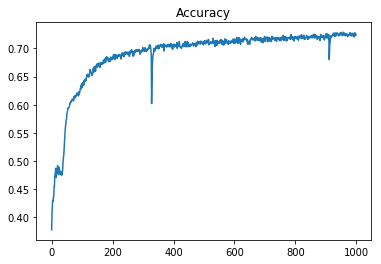

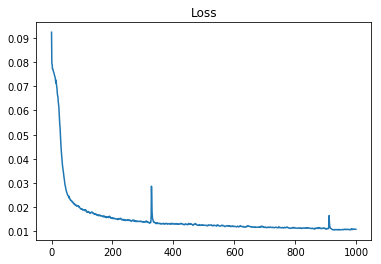

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9290 - acc: 0.7243
Epoch 2/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9288 - acc: 0.7264
Epoch 3/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9291 - acc: 0.7227
Epoch 4/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9291 - acc: 0.7224
Epoch 5/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0108 - image_closeness: 0.9292 - acc: 0.7249
Epoch 6/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0108 - image_closeness: 0.9294 - acc: 0.7259
Epoch 7/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0108 - image_closeness: 0.9292 - acc: 0.7224
Epoch 8/1000
1600/1600 [=============================

Epoch 61/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0110 - image_closeness: 0.9287 - acc: 0.7254
Epoch 62/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9288 - acc: 0.7251
Epoch 63/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9287 - acc: 0.7251
Epoch 64/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0110 - image_closeness: 0.9286 - acc: 0.7229
Epoch 65/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0109 - image_closeness: 0.9289 - acc: 0.7217
Epoch 66/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0109 - image_closeness: 0.9291 - acc: 0.7281
Epoch 67/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0109 - image_closeness: 0.9289 - acc: 0.7238A: 1s - loss: 0.0109 - image_closeness: 0.9288 
Epoch 68/1000
1600/1600 [==============================] - 4s 3ms/step 

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0109 - image_closeness: 0.9290 - acc: 0.7245A: 3s - loss: 0.0110 - ima
Epoch 122/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0110 - image_closeness: 0.9284 - acc: 0.7247A: 0s - loss: 0.0110 - image_closeness: 0.9285 - a
Epoch 123/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0109 - image_closeness: 0.9291 - acc: 0.7256
Epoch 124/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0108 - image_closeness: 0.9293 - acc: 0.7246A: 0s - loss: 0.0108 - image_closeness: 0.9291 - acc: 0
Epoch 125/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0108 - image_closeness: 0.9295 - acc: 0.7241A: 4s - loss:
Epoch 126/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0108 - image_closeness: 0.9294 - acc: 0.7213
Epoch 127/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0107 - image_closeness: 0.9

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0108 - image_closeness: 0.9291 - acc: 0.7219A: 0s - loss: 0.0109 - image_closeness: 0.9289 - acc: 0.
Epoch 179/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0111 - image_closeness: 0.9282 - acc: 0.7223A: 3s - loss: 0.
Epoch 180/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0111 - image_closeness: 0.9280 - acc: 0.7241
Epoch 181/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0111 - image_closeness: 0.9279 - acc: 0.7246
Epoch 182/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0112 - image_closeness: 0.9277 - acc: 0.7166A: 0s - loss: 0.0112 - image_closeness: 0.9274 - acc:
Epoch 183/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0112 - image_closeness: 0.9276 - acc: 0.7194
Epoch 184/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0111 - image_closeness: 0.9280 - acc: 0.7209
E

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0104 - image_closeness: 0.9312 - acc: 0.7280
Epoch 238/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0104 - image_closeness: 0.9310 - acc: 0.7285
Epoch 239/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0106 - image_closeness: 0.9298 - acc: 0.7220
Epoch 240/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0106 - image_closeness: 0.9299 - acc: 0.7266
Epoch 241/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0106 - image_closeness: 0.9300 - acc: 0.7277A: 3s - loss: 0.0105 - i
Epoch 242/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0105 - image_closeness: 0.9303 - acc: 0.7240
Epoch 243/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0105 - image_closeness: 0.9302 - acc: 0.7230A: 2s - loss: 0.0105 - image_c
Epoch 244/1000
1600/1600 [==============================] - 4s 3ms/step 

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0111 - image_closeness: 0.9282 - acc: 0.7224A: 4s - loss: 0.
Epoch 299/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0111 - image_closeness: 0.9281 - acc: 0.7215
Epoch 300/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0111 - image_closeness: 0.9282 - acc: 0.7223
Epoch 301/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0110 - image_closeness: 0.9286 - acc: 0.7260
Epoch 302/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0108 - image_closeness: 0.9291 - acc: 0.7259
Epoch 303/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0108 - image_closeness: 0.9294 - acc: 0.7274
Epoch 304/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0107 - image_closeness: 0.9295 - acc: 0.7221
Epoch 305/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.93

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.9299 - acc: 0.7248
Epoch 359/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.9301 - acc: 0.7290
Epoch 360/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.9297 - acc: 0.7234A: 4s - loss: 0.
Epoch 361/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.9299 - acc: 0.7231A: 3s - loss: 0.0108 - image_closeness: 0.9292 - acc: 0. - ETA: 2s - loss: 0.0107 - image_
Epoch 362/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0105 - image_closeness: 0.9304 - acc: 0.7267
Epoch 363/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0104 - image_closeness: 0.9308 - acc: 0.7240
Epoch 364/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0104 - image_closeness: 0.9308 - acc: 0.7272
Epoch 365/1000
1600/

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.9300 - acc: 0.7222
Epoch 416/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0105 - image_closeness: 0.9304 - acc: 0.7297
Epoch 417/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.9300 - acc: 0.7262
Epoch 418/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.9300 - acc: 0.7310
Epoch 419/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.9303 - acc: 0.7291A: 1s - loss: 0.0104 - image_closeness
Epoch 420/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0107 - image_closeness: 0.9295 - acc: 0.7218
Epoch 421/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9289 - acc: 0.7232
Epoch 422/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 -

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0104 - image_closeness: 0.9309 - acc: 0.7297A: 2s - loss: 0.0101 - image_closeness: 0.9315 - acc - ETA: 1s - loss: 0.0103 - image_closeness: 0.9
Epoch 475/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0104 - image_closeness: 0.9310 - acc: 0.7260
Epoch 476/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9314 - acc: 0.7306A: 0s - loss: 0.0103 - image_closeness: 0.9313 - acc: 0.73 - ETA: 0s - loss: 0.0103 - image_closeness: 0.9312 - acc: 0.
Epoch 477/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0102 - image_closeness: 0.9317 - acc: 0.7309
Epoch 478/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9315 - acc: 0.7285
Epoch 479/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9311 - acc: 0.7294
Epoch 480/1000
1600/1600 [========

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0104 - image_closeness: 0.9310 - acc: 0.7318A: 0s - loss: 0.0104 - image_closeness: 0.9308 - acc: 0.72 - ETA: 0s - loss: 0.0104 - image_closeness: 0.9309 - acc: 0.7
Epoch 528/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9314 - acc: 0.7305
Epoch 529/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9314 - acc: 0.7312
Epoch 530/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0106 - image_closeness: 0.9298 - acc: 0.7209
Epoch 531/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0109 - image_closeness: 0.9288 - acc: 0.7201
Epoch 532/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0108 - image_closeness: 0.9290 - acc: 0.7246A: 2s - loss: 0.0108 - image_c
Epoch 533/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0108 - image_closenes

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0102 - image_closeness: 0.9315 - acc: 0.7305
Epoch 589/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0105 - image_closeness: 0.9302 - acc: 0.7285A: 2s - loss: 0.0107 - image_
Epoch 590/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0104 - image_closeness: 0.9308 - acc: 0.7283
Epoch 591/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0102 - image_closeness: 0.9316 - acc: 0.7305
Epoch 592/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0102 - image_closeness: 0.9319 - acc: 0.7293
Epoch 593/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0102 - image_closeness: 0.9315 - acc: 0.7286
Epoch 594/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0103 - image_closeness: 0.9311 - acc: 0.7299
Epoch 595/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0104 - image_cl

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0102 - image_closeness: 0.9316 - acc: 0.7306
Epoch 646/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0102 - image_closeness: 0.9316 - acc: 0.7303
Epoch 647/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9314 - acc: 0.7293
Epoch 648/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0103 - image_closeness: 0.9312 - acc: 0.7293
Epoch 649/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0106 - image_closeness: 0.9300 - acc: 0.7272
Epoch 650/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0108 - image_closeness: 0.9291 - acc: 0.7252
Epoch 651/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0107 - image_closeness: 0.9297 - acc: 0.7277
Epoch 652/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0108 - image_closeness: 0.9292 - acc: 0.7257

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0121 - image_closeness: 0.9237 - acc: 0.7094A: 0s - loss: 0.0121 - image_closeness: 0.9237 - acc: 0.709
Epoch 706/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0121 - image_closeness: 0.9241 - acc: 0.7126A: 1s - loss: 0.0121 - image_closeness: 
Epoch 707/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0115 - image_closeness: 0.9261 - acc: 0.7149A: 2s - loss: 0.0116 - image_closene
Epoch 708/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0113 - image_closeness: 0.9268 - acc: 0.7207
Epoch 709/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0118 - image_closeness: 0.9249 - acc: 0.7126
Epoch 710/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0117 - image_closeness: 0.9255 - acc: 0.7143
Epoch 711/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0114 - image_closeness: 0.9264 - acc

1600/1600 [==============================] - 4s 3ms/step - loss: 0.0102 - image_closeness: 0.9317 - acc: 0.7289
Epoch 766/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0102 - image_closeness: 0.9314 - acc: 0.7256
Epoch 767/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0102 - image_closeness: 0.9314 - acc: 0.7303A: 0s - loss: 0.0102 - image_closeness: 0.9314 - acc:
Epoch 768/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9313 - acc: 0.7280
Epoch 769/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0102 - image_closeness: 0.9313 - acc: 0.7321
Epoch 770/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0102 - image_closeness: 0.9318 - acc: 0.7317
Epoch 771/1000
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0101 - image_closeness: 0.9322 - acc: 0.7340
Epoch 772/1000
1600/1600 [==============================] - 4s 3ms/step -

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9309 - acc: 0.7242A: 2s - loss: 0.0104 - image_closeness
Epoch 825/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9313 - acc: 0.7282
Epoch 826/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9310 - acc: 0.7283
Epoch 827/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9313 - acc: 0.7331A: 0s - loss: 0.0103 - image_closeness: 0.9312 - acc: 0.7
Epoch 828/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0102 - image_closeness: 0.9314 - acc: 0.7245
Epoch 829/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0102 - image_closeness: 0.9314 - acc: 0.7284A: 2s - loss: 0.0102 - image_closeness: 0.9316 - acc: 0.72 - ETA: 2s - loss: 0.0102 - image_closene
Epoch 830/1000
1600/1600 [==============================] -

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0101 - image_closeness: 0.9321 - acc: 0.7328
Epoch 879/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0101 - image_closeness: 0.9319 - acc: 0.7258
Epoch 880/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0101 - image_closeness: 0.9322 - acc: 0.7317
Epoch 881/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0100 - image_closeness: 0.9324 - acc: 0.7322
Epoch 882/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0100 - image_closeness: 0.9322 - acc: 0.7343A: 3s - loss: 0.0101
Epoch 883/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0102 - image_closeness: 0.9316 - acc: 0.7285
Epoch 884/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0102 - image_closeness: 0.9315 - acc: 0.7341
Epoch 885/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0105 - image_closeness: 0.9301 - acc: 0.7286A: 1s - loss: 0.0104 - image_closeness: 0.9302 
Epoch 939/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0105 - image_closeness: 0.9299 - acc: 0.7249
Epoch 940/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0104 - image_closeness: 0.9307 - acc: 0.7302
Epoch 941/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9310 - acc: 0.7313
Epoch 942/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0103 - image_closeness: 0.9313 - acc: 0.7296
Epoch 943/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0101 - image_closeness: 0.9318 - acc: 0.7317A: 0s - loss: 0.0101 - image_closeness: 0.9319 - acc: 0.731
Epoch 944/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0101 - image_closeness: 0.9321 - acc: 0.7316
Epoch 945/1000
1600/

1600/1600 [==============================] - 5s 3ms/step - loss: 0.0100 - image_closeness: 0.9322 - acc: 0.7295A: 1s - loss: 0.0099 - image_closeness: 0.9326 - 
Epoch 992/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0100 - image_closeness: 0.9324 - acc: 0.7313A: 4s - loss
Epoch 993/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0100 - image_closeness: 0.9324 - acc: 0.7304
Epoch 994/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0100 - image_closeness: 0.9324 - acc: 0.7325
Epoch 995/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0100 - image_closeness: 0.9325 - acc: 0.7323
Epoch 996/1000
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0100 - image_closeness: 0.9323 - acc: 0.7311
Epoch 997/1000
1600/1600 [==============================] - ETA: 0s - loss: 0.0100 - image_closeness: 0.9321 - acc: 0.7283- ETA: 4s - loss: 0. - 5s 3ms/step - loss: 0.0101 - image_closeness: 0

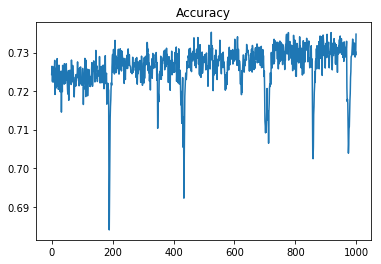

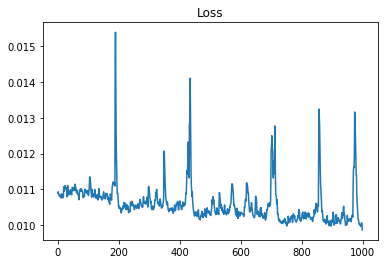

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [91]:
for i in range (1, 3):
    history = model_text2img.fit(captions_X, imgs_y, epochs=1000, batch_size=32, shuffle=True)
    print(str(i) + 'k epochs~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    model_text2img.save('.\\text2img-models-v4\\text2img-' + str(i) + 'k-epochs.h5')
    plot_history(history)
#     show_converted(4)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

In [80]:
# model_text2img = load_model('./text2img-models-v2/text2img-1k-epochs.h5')
model_text2img.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 27, 100)           0         
_________________________________________________________________
textencoder (Model)          (None, 32, 32, 32)        4542844   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       51763     
Total params: 4,594,607
Trainable params: 4,536,522
Non-trainable params: 58,085
_________________________________________________________________


a white dog holding a purple frisbee in it's mouth.


C:\Users\woodw\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


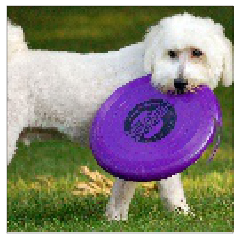

<Figure size 432x288 with 0 Axes>

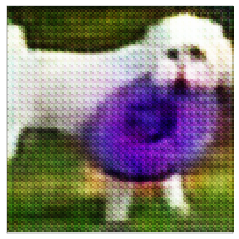

In [111]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
def rgb_imshow(img):
    figure(num=None, figsize=(10, 10), dpi=30, facecolor='w', edgecolor='k')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cv2.cvtColor((img).astype(np.float32), cv2.COLOR_BGR2RGB))
#     plt.show()
def show_converted(img_index, step_count=None, caption=None):
    # print(caption_strings[img_index])
    figure()
    if caption is None:
        img_input = imgs_y[img_index] #subset_X[img_index]
        plt.subplot(1,2,2)
        plt.title("Target image")
        rgb_imshow(img_input)
    
#     plt.subplot(1,2,1)
    
    if caption is None:
        plt.title("Image generated from:\n\"" + caption_strings[img_index] +"\"")
        decoded_img = model_text2img.predict(np.array([captions_X[img_index]]), steps=step_count)[0]
    else:
        decoded_img = model_text2img.predict(np.array([caption]), steps=step_count)[0]
    
#     figure(num=None, figsize=(10, 10), facecolor='w', edgecolor='k')
    rgb_imshow(decoded_img)
#     plt.savefig('./gru-testing/gru-1024-dense-1024-residual/img-' + str(img_index),bbox_inches='tight')


# show_converted(2)
# show_converted(4)
# show_converted(18)
# show_converted(65)
# for i in range(65, 70):


img_num = 69
print(caption_strings[img_num])
rgb_imshow(imgs_all[img_num])
show_converted(3, caption=caption_encoding(caption_strings[img_num]))



# decoded_img1 = model_text2img.predict(np.array([captions_X[4]]))[0]
# decoded_img2 = model_text2img.predict(np.array([captions_X[5]]))[0]

# flat_img = np.array(decoded_img2 - decoded_img1)
# flat_img = flat_img.flatten()
# nonzero_elems = [x for x in flat_img if x != 0]
# print (len(decoded_img1.flatten()))
# print (len(nonzero_elems))
# print (np.max(flat_img))


In [32]:
def caption_encoding(string):
    caption_conv = []
    for word in word_tokenize(string.lower()):
        caption_conv.append(w2v_model[word])
    caption_conv = np.array(caption_conv)
    caption_conv.resize((27, 100))
    return caption_conv

In [30]:
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.title("Accuracy")
    plt.show()
    plt.plot(history.history['loss'])
    plt.title("Loss")
    plt.show()

In [ ]:
np.shape(model_text2img.predict(np.array([captions_X[0]]))[0])

In [214]:
for cap in caption_strings:
    if 'man' in cap:
        print (cap)

woman in swim suit holding parasol on sunny day.
a young man riding a skateboard into the air.
a man riding a motor bike across a forest.
woman cutting pizza with fork and knife sitting next to young girl
a man and woman cut into a big cake 
a female in military uniform cutting a businessman's neck tie
a man standing holding a game controller and two people sitting
a man standing in front of a microwave next to pots and pans.
a man tossing an orange frisbee on top of a lush green field.
a man holding a glass of wine on it's side.
a man with a bushy beard and green tie.
a man talking on his phone in the public.
a cat is lying on its back in a man's lap.
a standing woman with a remote control in hand 
a man holding a camera up over his left shoulder.
a man getting ready to bunt the baseball
a man holding his hands together while sitting on a bench.
man on dirt bike with a redheaded woman in his lap.
a man standing next to a large red bus.
people gather around as a man gets into an old-ti

In [211]:
w2v_model.most_similar('pizza')

C:\Users\woodw\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('sandwich', 0.7644851803779602),
 ('cake', 0.7399096488952637),
 ('bread', 0.7351022362709045),
 ('food', 0.7136834859848022),
 ('doughnut', 0.7128810882568359),
 ('pizzas', 0.7076917886734009),
 ('dessert', 0.7038589119911194),
 ('pie', 0.6961496472358704),
 ('meal', 0.6948972940444946),
 ('knife', 0.6794041991233826)]

In [ ]:
from keras.utils import plot_model

plot_model(model_intermediate,  show_shapes=True, to_file='./vis/text2img-vis.jpg')